In [ ]:
# GET PARAMETERS
import os 
import sys
import torch 
import torch
torch.autograd.set_detect_anomaly(True)
if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32  = True
# Get Parent folder : 

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from plotting.plotting import error_per_station_calendar_pattern  
from examples.benchmark import local_get_args
from examples.train_and_visu_non_recurrent import evaluate_config,train_the_config,get_ds
from high_level_DL_method import load_optimizer_and_scheduler
from dl_models.full_model import full_model
from trainer import Trainer

for model_name in ['STGCN']: # ['ASTGCN','STGformer','STGCN','STAEformer']
    # Init:
    #['subway_indiv','tramway_indiv','bus_indiv','velov','criter']
    target_data = 'subway_in' #'subway_in'  # PeMS03 # PeMS04 # PeMS07 # PeMS08 # METR_LA 
    dataset_names = ['subway_in','netmob_POIs'] #['PeMS03'] #['subway_in'] ['subway_in','subway_indiv'] #["subway_in","subway_out"] # ['subway_in','netmob_POIs_per_station'],["subway_in","subway_out"],["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
    dataset_for_coverage = ['subway_in','netmob_image_per_station']#['subway_in','subway_indiv'] # ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
    #model_name = 'STGCN' # 'STGCN', 'ASTGCN',
    station = ['PAR']#['BEL','PAR','AMP','SAN','FLA']# [313344,313349,313438,313450]# ['BEL','PAR','AMP','SAN','FLA']   # 'BON'  #'GER'
    # ...

    # Modif 
    modification = {'target_data': target_data, 
                    'freq': '15min', #  '5min', 
                    'step_ahead': 4,
                    'use_target_as_context': False,
                    'data_augmentation': False,
                    'batch_size':128,

                    #'set_spatial_units':  station,   

                    'stacked_contextual': True, # True # False
                    'temporal_graph_transformer_encoder': False,
                    'need_global_attn' : False, # True ??

                    ### Denoising: 
                    #'denoising_names':['subway_in','subway_out'],
                    #'denoiser_names':["savitzky_golay"],   # ['median'], ['exponential'], ['savitzky_golay']         # un seul filtre
                    #'denoising_modes':["train"],             # par défaut
                    #'denoiser_kwargs':{'savitzky_golay': {'window': 5, 'poly': 2}}, # {'savitzky_golay': {'window': 5, 'poly': 2}} # {'exponential': {'alpha':0.3}} # {"median": {"kernel_size": 2}}

                    #
                    #'graph_conv_type': 'graph_conv', # 'cheb_graph_conv', 'graph_conv'
                    #'learnable_adj_top_k': 10,
                    #'learnable_adj_embd_dim': 16, 
                    ### ========

                    ### Temporal Graph Transfermer Encoder parametrs:
                    #'TGE_num_layers' : 4, #2
                    #'TGE_num_heads' :  1, #IMPOSSIBLE > 1 CAR DOIT DIVISER L = 7
                    #'TGE_FC_hdim' :  32, #32

                    ### Netmob Parametrs: 
                    #'NetMob_only_epsilon': True,    # True # False
                    #'NetMob_selected_apps': ['Apple_iMessage','Web_Ads'],# ['Apple_iMessage','Web_Ads'], #,'Deezer','WhatsApp','Twitter'] #['Google_Maps']# ['Instagram','Google_Maps','Twitter']
                    #'NetMob_transfer_mode' :  ['DL'], #,'UL'] # ['DL'] # ['UL'] #['DL','UL']
                    #'NetMob_selected_tags' : ['station_epsilon100'],#['iris','stadium','station','university']#['park','stadium','university','station','shop','nightclub','parkings','theatre','iris','transit','public_transport']
                    #'NetMob_expanded' : '', # '' # '_expanded

                    ### Compute node with attention parameters: 
                    #'vision_num_heads':6,
                    #"vision_grn_out_dim":48,
                    #'vision_model_name': 'VariableSelectionNetwork',
                    #'vision_concatenation_early':True,   
                    #'vision_concatenation_late':True,
                            }
    if model_name == 'STAEformer':
        modification.update({'dataset_names' : ['subway_in','subway_out','calendar'],
                             'calendar_types' : ['dayofweek','timeofday'] ,
                                "input_embedding_dim": 8, # choices = [16, 24, 32, 48, 64]
                                "tod_embedding_dim": 4, # choices = [0, 4, 8, 12, 16]
                                "dow_embedding_dim": 4, # choices = [0, 4, 8, 12, 16]
                                "adaptive_embedding_dim": 32, # choices = [8, 12, 16, 24]

                                # Architecture:
                                "num_heads": 2, # choices = [1, 2, 4, 8]
                                "num_layers": 4, # choices = [1, 2, 3, 4, 6]
                                "feed_forward_dim": 16, # choices = [16, 32, 64, 128]
                                "epochs":1000
                                })
        
    if model_name == 'STGformer':
        modification.update({'dataset_names' : ['subway_in','subway_out','calendar'],
                             'calendar_types' : ['dayofweek','timeofday'] ,
                                "input_embedding_dim": 64, # choices = [16, 24, 32, 48, 64]
                                "tod_embedding_dim": 0, # choices = [0, 4, 8, 12, 16]
                                "dow_embedding_dim": 0, # choices = [0, 4, 8, 12, 16]
                                "adaptive_embedding_dim": 8, # choices = [8, 12, 16, 24]

                                # Attention
                                "num_heads": 1, # choices = [1, 2, 4, 8]
                                "num_layers": 1, # choices = [1, 2, 3, 4, 6]
                                "mlp_ratio": 2.8, # choices = [1.0, 1.5, 2.0, 2.5, 3.0]  # PAS SUR 

                                # Projections et dropout
                                "dropout_a": 0.18, # choices = uniform(0.0, 0.5)

                                # Kernel sizes pour la projection temporelle
                                "kernel_size": [1, 1], # choices = [[1], [3], [1, 3], [3, 5]]

                                'weight_decay': 0.0759064974349492,
                                'lr': 0.00252,
                                'dropout': 0.0960421340920108,
                                'epochs': 500,
                                'scheduler': True,
                                'torch_scheduler_milestone': 18.0,
                                'torch_scheduler_gamma': 0.9916155881533422,
                                'torch_scheduler_lr_start_factor': 0.9934025526552662
                                })
    if model_name == 'STGCN':
        modification.update({'Kt': 2,
                            'stblock_num': 3,
                            'gso_type': 'sym_renorm_adj',
                            'temporal_h_dim': 256,
                            'spatial_h_dim': 32,
                            'output_h_dim': 16,
                            'adj_type':'corr',
                            'threshold': 0.7,
                            'learnable_adj_matrix' : False, # True                              # EXIST ONLY IF MODEL = STGCN
                            'graph_conv_type': 'graph_conv', # 'cheb_graph_conv', 'graph_conv'  # EXIST ONLY IF MODEL = STGCN
                            'learnable_adj_top_k': 10,                                          # EXIST ONLY IF MODEL = STGCN
                            'learnable_adj_embd_dim': 16,                                       # EXIST ONLY IF MODEL = STGCN  


                            'epochs' : 10, #100

                            'lr': 0.00105, # 5e-5,# 4e-4,
                            'weight_decay': 0.0188896655584368, # 0.05,
                            'dropout': 0.271795372610271, # 0.15,

                            'scheduler': True,  # None
                            'torch_scheduler_milestone': 28.0, #5,
                            'torch_scheduler_gamma': 0.9958348861339396, # 0.997,
                            'torch_scheduler_lr_start_factor': 0.8809942312067847, # 1,
                         })


    modification.update({'num_workers' : 4, # 0,1,2, 4, 6, 8 ... A l'IDRIS ils bossent avec 6 num workers par A100 80GB
                        'persistent_workers' : True ,# False 
                        'pin_memory' : True ,# False 
                        'prefetch_factor' : 4, # None, 2,3,4,5 ... 
                        'drop_last' : False,  # True
                        'mixed_precision' : False, # True # False
                        'torch_compile' : False #'jit_script', #'jit_script' # 'compile' # False
    })
    # ...

    # Training and visu: 
    args_init = local_get_args(model_name,
                        args_init = None,
                        dataset_names=dataset_names,
                        dataset_for_coverage=dataset_for_coverage,
                        modification = modification)

    training_mode_to_visualise = ['test'] # ['test','valid','train']

    if False:
        ds,args,trial_id,save_folder,df_loss = get_ds(modification=modification,args_init=args_init)
        model = full_model(ds, args).to(args.device)
        optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
        trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler,show_figure = False,trial_id = trial_id, fold=0,save_folder = save_folder)
        trainer.train_and_valid(normalizer = ds.normalizer, mod = 1000,mod_plot = None) 

    else:
        torch.autograd.set_detect_anomaly(True)
        (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_init = args_init,
                                                        station=station,modification=modification,
                                                        training_mode_to_visualise=training_mode_to_visualise)

----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2819, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([939, 40, 7])

>>>Tackle Contextual dataset:  subway_out
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_out/subway_out.csv
   Init Dataset: '[torch.Size([7392, 40])]. [tensor(0)] Nan values
   TRAIN contextual_ds: [torch.Size([2819, 40, 7])]
   VALID contextual_ds: [torch.Size([940, 40, 7])]
   TEST contextual_ds: [torch.Size([939, 40, 7])]
Init U/Utarget size: torch.Size([4699, 40, 7])/torch.Size([4699, 40, 4]) Train/Valid/Test 28

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:152: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Training Throughput:667.99 sequences per seconds
>>> Training complete in: 0:28:48.348593
>>> Training (64.47%) performance time: min 0.14 avg 1.72e-01 seconds (+/- 2.79e-02)
>>> Loading (35.05%) performance time: min 0.00 avg 9.10e-02 seconds (+/- 8.85e-02)
>>> Forward  (43.49%) performance time: 1.19e-01 seconds (+/- 2.01e-02)
>>> Backward  (20.92%) performance time: 5.73e-02 seconds (+/- 1.63e-02)
>>> Plotting  (0.00%) performance time: 2.44e-06 seconds (+/- 7.14e-06)
>>> Saving  (0.54%) performance time: 2.35e-01 seconds (+/- 5.69e-02)
>>> PI-tracking  (0.00%) performance time: 4.44e-06 seconds (+/- 3.20e-06)
>>> Scheduler update  (0.00%) performance time: 2.88e-05 seconds (+/- 1.14e-05)
>>> Validation time: 0:00:00.084840

Max GPU memory allocated: 0.5847682952880859 GB
Max GPU memory cached: 0.62890625 GB
Max CPU memory allocated: 2.7736473083496094 GB
None

--------------------------------------------------
Reload dataset without shuffling on train set, and remove data_augmenta

Loading BokehJS ...

In [4]:
import os 
import sys
import torch 
import importlib

if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32  = True
# Get Parent folder : 

current_file_path = os.path.abspath(os.getcwd())
parent_dir = os.path.abspath(os.path.join(current_file_path,'..'))
if parent_dir not in sys.path:
    sys.path.insert(0,parent_dir)

from examples.benchmark import local_get_args
from utils.rng import set_seed
from examples.train_and_visu_non_recurrent import evaluate_config

target_data = 'subway_in' # 'PeMS08_flow' # 'CRITER_3_4_5_lanes_flow' #'subway_in'  # PeMS03 # PeMS04 # PeMS07 # PeMS08 # METR_LA # criter
model_name = 'STGCN' # 'STGCN', 'ASTGCN', 'STGformer', 'STAEformer'
training_mode_to_visualise = ['test'] # ['test','valid','train']
station = ['PAR']
   

from examples.reproductibility.config_STGCN_Subway_in_NetMob_calendar import modifications as modifications


# import torch._dynamo as dynamo; dynamo.graph_break()
# torch._dynamo.config.verbose=True
compilation_modification = {
                            'num_workers' : 4, # 0,1,2, 4, 6, 8 ... A l'IDRIS ils bossent avec 6 num workers par A100 80GB
                            'persistent_workers' : True ,# False 
                            'pin_memory' : True ,# False 
                            'prefetch_factor' : 4, # None, 2,3,4,5 ... 
                            'drop_last' : False,  # True
                            'mixed_precision' : False, # True # False
                            'torch_compile' : False, # 'compile', # 'compile', # 'compile', #'compile' # 'jit_script' #'trace' # False
                            'unormalize_loss' : True, # False

                            'device': torch.device('cuda:1')
    }
        
SEED = 1
modification_init = {}
set_seed(SEED)


log_final  = f"\n--------- Resume ---------\n"
subfolder = f'{target_data}_{model_name}'
trial_id,modification_i = list(modifications.items())[0]
config = modification_init.copy()
config.update(compilation_modification)
config.update(modification_i)
config['epochs'] = 100

args_init = local_get_args(model_name,
                args_init = None,
                dataset_names=config['dataset_names'],
                dataset_for_coverage=config['dataset_for_coverage'],
                modification = config)
fold_to_evaluate=[args_init.K_fold-1]

(trainer,ds,ds_no_shuffle,args) = evaluate_config(args_init = args_init,
                                                station=station,modification=config,
                                                training_mode_to_visualise=training_mode_to_visualise,
                                                fold_to_evaluate = fold_to_evaluate)

# try:
#     grad_norms = trainer.model.core_model.output.ModuleContextualAttnLate.netmob_POIs.mha.attention_grad_norms
# except:
#     grad_norms = trainer.model.spatial_attn_poi.netmob_POIs.mha.attention_grad_norms




----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: //home/rrochas/../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2819, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([939, 40, 7])

>>>Loading calendar embedding inputs ...
    dict_keys(['dayofweek_OHE', 'hour_OHE'])
   args_embedding.variable_selection_model_name:  MLP

>>>Tackle Contextual dataset:  netmob_POIs
    ATTENTION: Dimension reduction by clustering is applied on the entire dataset. This should be done only on the training set.
    Netmob_T.size(): torch.Size([7392, 169]). Dimensionality reduced by 15.5%


Restraining all datasets to train common dates: 2819 dates
Res

Loading BokehJS ...

(0.0, 20.0)

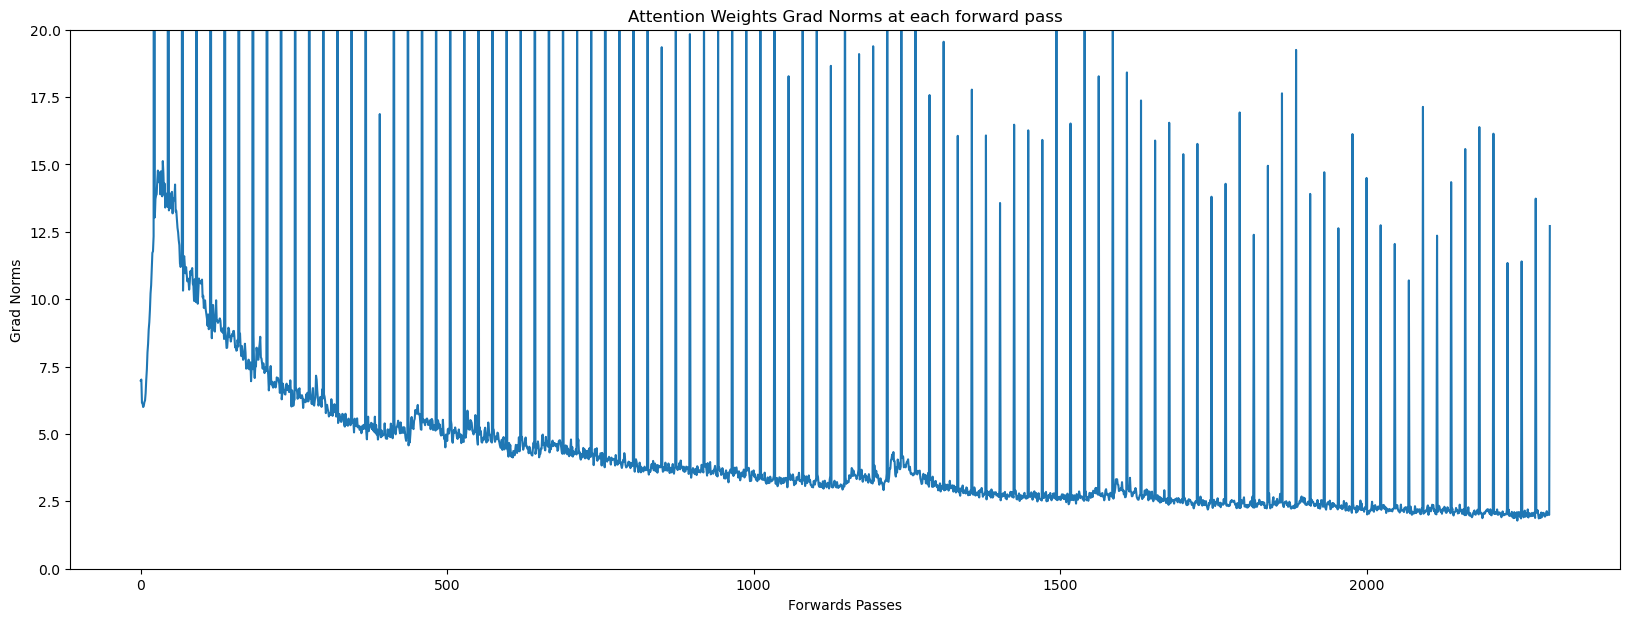

In [5]:
import matplotlib.pyplot as plt
import pandas as pd
try:
    grad_norms = trainer.model.core_model.output.ModuleContextualAttnLate.netmob_POIs.mha.attention_grad_norms
except:
    grad_norms = trainer.model.spatial_attn_poi.netmob_POIs.mha_list[0].mha.attention_grad_norms

pd.Series(grad_norms).plot(title = 'Attention Weights Grad Norms at each forward pass',ylabel = 'Grad Norms',xlabel = 'Forwards Passes',figsize=(20,7))
plt.ylim(0,20)

In [8]:

for st_block_num in range(len(trainer.model.core_model.st_blocks)):
    print('ST-Conv Block: ',st_block_num)
    print("    norm 'conv2D' of tmp-conv1:          ",trainer.model.core_model.st_blocks[st_block_num].tmp_conv1.causal_conv.conv2d.weight.grad.norm().detach().cpu().item())
    print("    norm learnable weight of graph conv: ",trainer.model.core_model.st_blocks[st_block_num].graph_conv.graph_conv.weight.grad.norm().detach().cpu().item())
    print("    norm 'conv2D' of tmp-conv2:          ",trainer.model.core_model.st_blocks[st_block_num].tmp_conv2.causal_conv.conv2d.weight.grad.norm().detach().cpu().item())

print('\nAttention Module:' )
print('  MHA:  ')
for mha_layer in range(len(trainer.model.spatial_attn_poi.netmob_POIs.mha_list)):
    print('    W_q:                                 ',trainer.model.spatial_attn_poi.netmob_POIs.mha_list[mha_layer].mha.W_q.grad.norm().detach().cpu().item())
    print('    W_k:                                 ',trainer.model.spatial_attn_poi.netmob_POIs.mha_list[mha_layer].mha.W_k.grad.norm().detach().cpu().item())
    print('    W_v:                                 ',trainer.model.spatial_attn_poi.netmob_POIs.mha_list[mha_layer].mha.W_v.grad.norm().detach().cpu().item())
    try: 
        print('    norm of LayerNorm:                   ',trainer.model.spatial_attn_poi.netmob_POIs.mha_list[mha_layer].mha.layer_norm.weight.grad.norm().detach().cpu().item())  
    except: 
        print('    norm of LayerNorm q:                 ',trainer.model.spatial_attn_poi.netmob_POIs.mha_list[mha_layer].mha.layer_normq.weight.grad.norm().detach().cpu().item())  
        print('    norm of LayerNorm kv:                ',trainer.model.spatial_attn_poi.netmob_POIs.mha_list[mha_layer].mha.layer_normkv.weight.grad.norm().detach().cpu().item())  
    print('  FC layers: ')
    print('    norm FC1:                            ',trainer.model.spatial_attn_poi.netmob_POIs.mha_list[mha_layer].feedforward[0].weight.grad.norm().detach().cpu().item())
    print('    norm FC1:                            ',trainer.model.spatial_attn_poi.netmob_POIs.mha_list[mha_layer].feedforward[2].weight.grad.norm().detach().cpu().item())


ST-Conv Block:  0
    norm 'conv2D' of tmp-conv1:           1.5110981464385986
    norm learnable weight of graph conv:  24.83087730407715
    norm 'conv2D' of tmp-conv2:           8.803756713867188
ST-Conv Block:  1
    norm 'conv2D' of tmp-conv1:           6.089472770690918
    norm learnable weight of graph conv:  4.602596759796143
    norm 'conv2D' of tmp-conv2:           5.951825141906738
ST-Conv Block:  2
    norm 'conv2D' of tmp-conv1:           4.129796504974365
    norm learnable weight of graph conv:  3.386009454727173
    norm 'conv2D' of tmp-conv2:           6.137971878051758
ST-Conv Block:  3
    norm 'conv2D' of tmp-conv1:           5.70151948928833
    norm learnable weight of graph conv:  6.071232318878174
    norm 'conv2D' of tmp-conv2:           9.596473693847656

Attention Module:
  MHA:  
    W_q:                                  0.2630208730697632
    W_k:                                  0.29969412088394165
    W_v:                                  6.5418415069580

In [1]:

# Init:
#['subway_indiv','tramway_indiv','bus_indiv','velov','criter']
target_data = 'subway_in' #'subway_in'  # PeMS03 # PeMS04 # PeMS07 # PeMS08 # METR_LA 
dataset_names = ['subway_in','subway_out'] #['PeMS03'] #['subway_in'] ['subway_in','subway_indiv'] #["subway_in","subway_out"] # ['subway_in','netmob_POIs_per_station'],["subway_in","subway_out"],["subway_in","calendar"] # ["subway_in"] # ['data_bidon'] # ['METR_LA'] # ['PEMS_BAY']
dataset_for_coverage = ['subway_in','netmob_image_per_station']#['subway_in','subway_indiv'] # ['subway_in','netmob_image_per_station'] #  ['data_bidon','netmob'] #  ['subway_in','netmob']  # ['METR_LA'] # ['PEMS_BAY']
model_name = 'STGformer' # 'STGCN', 'ASTGCN' # 'STGformer'
#station = ['BEL','PAR','AMP','SAN','FLA']# ['BEL','PAR','AMP','SAN','FLA']   # 'BON'  #'GER'
# ...

# Modif 
modification = {'target_data': target_data, 
                    'freq': '15min', #  '5min', 
                    'step_ahead': 4,
                    'use_target_as_context': False,
                    'data_augmentation': False,
            
                    'epochs' : 1, #100

                    'lr': 0.00105, # 5e-5,# 4e-4,
                    'weight_decay': 0.0188896655584368, # 0.05,
                    'dropout': 0.271795372610271, # 0.15,

                    'scheduler': True,  # None
                    'torch_scheduler_milestone': 28.0, #5,
                    'torch_scheduler_gamma': 0.9958348861339396, # 0.997,
                    'torch_scheduler_lr_start_factor': 0.8809942312067847, # 1,


                    #'set_spatial_units':  station,   

                    'stacked_contextual': True, # True # False
                    'temporal_graph_transformer_encoder': False,
                    'need_global_attn' : False, # True ??

                    ### Denoising: 
                    'denoising_names':['subway_in','subway_out'],
                    'denoiser_names':["savitzky_golay"],   # ['median'], ['exponential'], ['savitzky_golay']         # un seul filtre
                    'denoising_modes':["train"],             # par défaut
                    'denoiser_kwargs':{'savitzky_golay': {'window': 5, 'poly': 2}}, # {'savitzky_golay': {'window': 5, 'poly': 2}} # {'exponential': {'alpha':0.3}} # {"median": {"kernel_size": 2}}

                    #
                    #'graph_conv_type': 'graph_conv', # 'cheb_graph_conv', 'graph_conv'
                    #'learnable_adj_top_k': 10,
                    #'learnable_adj_embd_dim': 16, 
                    ### ========

                    ### Temporal Graph Transfermer Encoder parametrs:
                    #'TGE_num_layers' : 4, #2
                    #'TGE_num_heads' :  1, #IMPOSSIBLE > 1 CAR DOIT DIVISER L = 7
                    #'TGE_FC_hdim' :  32, #32

                    ### Netmob Parametrs: 
                    #'NetMob_only_epsilon': True,    # True # False
                    #'NetMob_selected_apps': ['Apple_iMessage','Web_Ads'],# ['Apple_iMessage','Web_Ads'], #,'Deezer','WhatsApp','Twitter'] #['Google_Maps']# ['Instagram','Google_Maps','Twitter']
                    #'NetMob_transfer_mode' :  ['DL'], #,'UL'] # ['DL'] # ['UL'] #['DL','UL']
                    #'NetMob_selected_tags' : ['station_epsilon100'],#['iris','stadium','station','university']#['park','stadium','university','station','shop','nightclub','parkings','theatre','iris','transit','public_transport']
                    #'NetMob_expanded' : '', # '' # '_expanded

                    ### Compute node with attention parameters: 
                    #'vision_num_heads':6,
                    #"vision_grn_out_dim":48,
                    #'vision_model_name': 'VariableSelectionNetwork',
                    #'vision_concatenation_early':True,   
                    #'vision_concatenation_late':True,
                            }
if model_name == 'STGformer':
    dataset_names.append('calendar')
    modification.update({ "input_embedding_dim": 16, # choices = [16, 24, 32, 48, 64]
                            "tod_embedding_dim": 2, # choices = [0, 4, 8, 12, 16]
                            "dow_embedding_dim": 2, # choices = [0, 4, 8, 12, 16]
                            "adaptive_embedding_dim": 12, # choices = [8, 12, 16, 24]

                            # Attention
                            "num_heads": 8, # choices = [1, 2, 4, 8]
                            "num_layers": 3, # choices = [1, 2, 3, 4, 6]
                            "mlp_ratio": 2, # choices = [1.0, 1.5, 2.0, 2.5, 3.0]  # PAS SUR 

                            # adaptive embeddingdropout 
                            "dropout_a": 0.3, # choices = uniform(0.0, 0.5)

                            # Kernel sizes pour la projection temporelle
                            "kernel_size": [1], # choices = [[1], [3], [1, 3], [3, 5]]

                            # gso:
                            'adj_normalize_method': 'normlap', # choices = ['normlap','scalap','symadj','transition','doubletransition','identity']
    
    })
if model_name == 'STGCN':
    modification.update({'Kt': 2,
                        'stblock_num': 3,
                        'gso_type': 'sym_renorm_adj',
                        'temporal_h_dim': 256,
                        'spatial_h_dim': 32,
                        'output_h_dim': 16,
                        'adj_type':'corr',
                        'threshold': 0.7,
                        'learnable_adj_matrix' : False, # True                              # EXIST ONLY IF MODEL = STGCN
                        'graph_conv_type': 'graph_conv', # 'cheb_graph_conv', 'graph_conv'  # EXIST ONLY IF MODEL = STGCN
                        'learnable_adj_top_k': 10,                                          # EXIST ONLY IF MODEL = STGCN
                        'learnable_adj_embd_dim': 16,                                       # EXIST ONLY IF MODEL = STGCN  
                        })

args_init = local_get_args(model_name,
                    args_init = None,
                    dataset_names=dataset_names,
                    dataset_for_coverage=dataset_for_coverage,
                    modification = modification)


def main():
    ds,args,trial_id,save_folder,df_loss = get_ds(modification=modification,args_init=args_init)
    model = full_model(ds, args).to(args.device)
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
    trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler,show_figure = False,trial_id = trial_id, fold=0,save_folder = save_folder)
    trainer.train_and_valid(normalizer = ds.normalizer, mod = 1000,mod_plot = None) 
    return trainer,ds,model,args


if __name__ == "__main__":
    import numpy as np 
    import random 
    SEED = 42
    def set_seed(seed=42):
        random.seed(seed)
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
    set_seed(SEED)

    # Run the script
    trainer,ds,model,args = main()
    print("Training completed successfully.")
    print(trainer.performance)

NameError: name 'local_get_args' is not defined

raw_values.shape torch.Size([1269, 40])
denoised_values.shape torch.Size([1269, 40])


<Axes: >

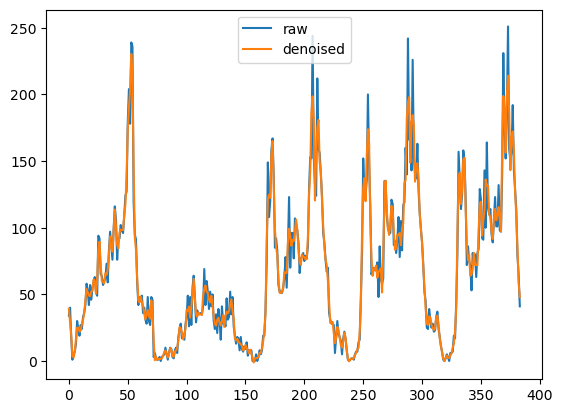

In [2]:
import torch 
import pandas as pd
training_mode = 'train'
raw_values = torch.index_select(ds.raw_values,0,torch.tensor(getattr(ds.tensor_limits_keeper,f"{training_mode}_indices"),dtype=torch.long))
denoised_values = ds.train_input
print('raw_values.shape',raw_values.shape)
print('denoised_values.shape',denoised_values.shape)
pd.DataFrame(dict(raw = raw_values.detach().cpu().numpy()[:,0], denoised = denoised_values.detach().cpu().numpy()[:,0])).iloc[:96*4].plot()

In [ ]:
import os 
import pandas as pd
import pickle
os.listdir('../../../../../data/rrochas/prediction_validation/METR_LA/')

import h5py
from constants.paths import FOLDER_PATH
FOLDER_PATH = os.path.expanduser(FOLDER_PATH)
FILE_BASE_NAME = 'METR_LA'#'subway_IN_interpol_neg_15_min_2019_2020' #.csv
DATA_SUBFOLDER = 'METR_LA'
dirname = f"{FOLDER_PATH}/{DATA_SUBFOLDER}"
data = h5py.File(f"{dirname}/{FILE_BASE_NAME}.h5", 'r')
axis0 = pd.Series(data['df']['axis0'][:].astype(str))
axis1 = pd.Series(data['df']['axis1'][:].astype(str))

before denoising: raw_value_i.mean(), max(), and size:  tensor(144.3139) tensor(1435.) torch.Size([3323, 40])
   dataset.name subway_in in denoising_names['subway_in']has been denoised
 
   future value: raw_value_i.mean(), max(), and size:  tensor(138.2645) tensor(1099.) torch.Size([3323, 40])

In [83]:
valid_distances =  pd.read_csv('../../../../../data/rrochas/prediction_validation/METR_LA/distances_la_2012.csv')
valid_distances.set_index(['from','to'], inplace=True)
valid_distances = valid_distances.values
sigma2 = valid_distances.var()
kernel = np.exp(-dist_i**2 / (2 * sigma2))
w_adj_dist = kernel[axis0.astype(int)].loc[axis0.astype(int)].fillna(0)
w_adj_dist

to,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
from,,,,,,,,,,,,,,,,,,,,,
773869,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.367281,0.0,0.000000,0.002511,0.000000,0.0,0.009526,0.000841
767541,0.000000,1.000000,0.641899,0.005611,0.005553,0.001564,0.001504,0.641512,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.178000,0.017628,0.012460,0.0,0.000000,0.000000
767542,0.000000,0.854917,1.000000,0.032239,0.032017,0.002700,0.002601,0.323578,0.000000,0.000000,...,0.000000,0.001773,0.000000,0.0,0.053762,0.013250,0.002029,0.0,0.000000,0.001072
717447,0.000000,0.037872,0.002234,1.000000,0.806283,0.074061,0.127208,0.002180,0.000000,0.000000,...,0.000000,0.084966,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.016794
717446,0.000000,0.045743,0.002832,0.801911,1.000000,0.244560,0.388847,0.002825,0.000000,0.000000,...,0.000000,0.025455,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.003682
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717592,0.000000,0.000000,0.000197,0.000000,0.000000,0.000000,0.000000,0.000705,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.002877,1.000000,0.309678,0.0,0.000000,0.000000
717595,0.000000,0.000296,0.001788,0.000000,0.000000,0.000000,0.000000,0.005316,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.0,0.023539,0.000000,1.000000,0.0,0.000000,0.000000
772168,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.002558,0.491317,...,0.385538,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,1.0,0.000000,0.000000


In [1]:
import torch, time
from torch.utils.data import DataLoader, TensorDataset

def benchmark(num_workers, batch=256, iters=100):
    ds = TensorDataset(torch.randn(50000, 128))
    if num_workers ==0:
        loader = DataLoader(ds, batch_size=batch, num_workers=num_workers,
                            pin_memory=True, persistent_workers=False)
    else:
        loader = DataLoader(ds, batch_size=batch, num_workers=num_workers,
                            pin_memory=True, persistent_workers=True)

    t0 = time.perf_counter()
    for i, (x,) in zip(range(iters), loader):
        x = x.cuda(non_blocking=True)
    torch.cuda.synchronize()
    return time.perf_counter() - t0

for batch_i in [16,32,64,128,256,512,1024]:
    print(' ')
    for w in [0, 2, 4, 8, 12]:
        print(f"{w:2d} workers et {batch_i}batch -> {benchmark(w,batch = batch_i):.2f}s (100 iters)")



 
 0 workers et 16batch -> 1.35s (100 iters)
 2 workers et 16batch -> 0.22s (100 iters)
 4 workers et 16batch -> 0.20s (100 iters)
 8 workers et 16batch -> 0.31s (100 iters)
12 workers et 16batch -> 0.43s (100 iters)
 
 0 workers et 32batch -> 0.02s (100 iters)
 2 workers et 32batch -> 0.17s (100 iters)
 4 workers et 32batch -> 0.22s (100 iters)
 8 workers et 32batch -> 0.34s (100 iters)
12 workers et 32batch -> 0.48s (100 iters)
 
 0 workers et 64batch -> 0.03s (100 iters)
 2 workers et 64batch -> 0.17s (100 iters)
 4 workers et 64batch -> 0.22s (100 iters)
 8 workers et 64batch -> 0.34s (100 iters)
12 workers et 64batch -> 0.53s (100 iters)
 
 0 workers et 128batch -> 0.04s (100 iters)
 2 workers et 128batch -> 0.17s (100 iters)
 4 workers et 128batch -> 0.22s (100 iters)
 8 workers et 128batch -> 0.32s (100 iters)
12 workers et 128batch -> 0.43s (100 iters)
 
 0 workers et 256batch -> 0.08s (100 iters)
 2 workers et 256batch -> 0.19s (100 iters)
 4 workers et 256batch -> 0.24s (100 

In [2]:
# 1. mesure DataLoader seul
for w in (0,2,4,6):
    print(w, benchmark(w, batch=256))   # ajuste batch

# 2. mesure boucle entraînement complète
torch.cuda.synchronize(); t0=time.perf_counter()
for i,(x,y) in enumerate(loader):
    with torch.cuda.amp.autocast(dtype=torch.bfloat16):
        loss = model(x.cuda()).square().mean()
    loss.backward(); opt.step(); opt.zero_grad()
    if i == 50: break
torch.cuda.synchronize(); print("50 iters :",time.perf_counter()-t0)

0 0.08918134029954672
2 0.19568584579974413
4 0.22675905283540487
6 0.27495975606143475


NameError: name 'loader' is not defined

In [135]:
import torch, time, pandas as pd
from torch.cuda.amp import autocast, GradScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Device:", device)

# tiny MLP
class TinyNet(torch.nn.Module):
    def __init__(self, D=1024):
        super().__init__()
        self.fc1 = torch.nn.Linear(D, D, bias=False)
        self.fc2 = torch.nn.Linear(D, D, bias=False)
    def forward(self, x):
        return self.fc2(torch.relu(self.fc1(x)))

def one_run(use_amp=False, dtype=torch.float16, use_scaler=False,
            tf32_matmul=False, tf32_cudnn=False, iters=1000,batch_size =1024):
    torch.backends.cuda.matmul.allow_tf32 = tf32_matmul
    torch.backends.cudnn.allow_tf32 = tf32_cudnn
    model = TinyNet().to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    scaler = GradScaler(enabled=use_amp and use_scaler)
    x = torch.randn(batch_size,1024, device=device)
    torch.cuda.synchronize()
    t0 = time.perf_counter()
    for _ in range(iters):
        opt.zero_grad(set_to_none=True)
        if use_amp:
            with autocast(dtype=dtype):
                y = model(x)
                loss = y.square().mean()
            if use_scaler:
                scaler.scale(loss).backward()
                scaler.step(opt)
                scaler.update()
            else:
                loss.backward()
                opt.step()
        else:
            y = model(x)
            loss = y.square().mean()
            loss.backward()
            opt.step()
    torch.cuda.synchronize()
    return time.perf_counter() - t0

configs = [
    ("FP32", False, torch.float32, False, False, False),
    ("FP32+TF32", False, torch.float32, False, True, True),
    ("AMP_FP16", True, torch.float16, True, True, True),
    ("AMP_BF16", True, torch.bfloat16, False, True, True),
]

records=[]
for name, amp, dtype, scaler, tf32mat, tf32cu in configs:
    t=one_run(use_amp=amp, dtype=dtype, use_scaler=scaler,
              tf32_matmul=tf32mat, tf32_cudnn=tf32cu)
    records.append({"Config":name,"Time (s)":t})

df=pd.DataFrame(records)
df



Device: cuda


,Config,Time (s)
0,FP32,1.271698
1,FP32+TF32,1.111132
2,AMP_FP16,1.833507
3,AMP_BF16,1.031148


                RMSE        MAE       MAPE
Step ahead                                 
1           29.932063  21.284523  17.047184
2           30.326398  21.460867  16.486710
3           30.578769  21.381296  16.177244
4           33.712780  23.897259  17.987389
5           33.536971  24.046694  18.772495
6           33.165545  23.271109  17.019117
7           34.660992  24.482054  17.726267
8           36.729103  26.229071  18.894775
9           37.518191  26.669842  19.906096
10          37.883416  26.882498  19.284714
11          39.781669  28.636337  20.814142
12          41.115753  29.567553  21.626381
RMSE    34.911804
MAE     24.817425
MAPE    18.478543
dtype: float64




Avec mixed precision: 
                 RMSE        MAE       MAPE
Step ahead                                 
1           28.175711  19.717287  15.374367
2           28.892655  20.078827  15.344498
3           29.720497  20.689669  15.622512
4           30.391395  21.097784  15.603343
5           30.699159  21.540882  16.086702
6           31.474671  21.978525  16.118176
7           32.850941  23.032909  16.502474
8           33.822253  23.801098  17.295534
9           35.468585  25.104759  17.864521
10          36.265235  25.710270  18.754314
11          37.766005  26.925425  19.438816
12          39.585240  28.359896  20.570312
RMSE    32.926029
MAE     23.169778
MAPE    17.047964
dtype: float64

Meilleurs réusltats, variation de 1%


Training completed successfully.
                  RMSE        MAE       MAPE
Step ahead                                  
1            63.295758  47.013775  40.570602
2            65.162931  48.732983  40.800812
3            65.498453  48.645287  41.526768
4            66.255347  49.002720  42.029232
5            95.240459  72.716331  42.568378
6            97.152732  74.267708  43.412182
7            98.008041  74.973328  44.059326
8            97.160793  74.278725  44.244614
9           104.852249  80.662521  47.231369
10           99.647440  76.215179  45.819050
11           76.052944  54.952339  45.097935
12           77.437368  55.980213  44.630604
RMSE    83.813710
MAE     63.120092
MAPE    43.499239


------------------------------------------------------------------------

Configuration : 
dataset: PeMS08

if torch.cuda.is_available():
    torch.backends.cuda.matmul.allow_tf32 = True
    torch.backends.cudnn.allow_tf32  = True

'num_workers' : 4,
'persistent_workers' : True ,
'pin_memory' : True ,
'prefetch_factor' : 4, 
'drop_last' : False,  
'mixed_precision' : False,

Pas de compilation 

Sortie: 
Training Throughput:2656.02 sequences per seconds
>>> Training complete in: 0:04:36.368053
>>> Training (55.94%) performance time: min 0.06 avg 9.63e-02 seconds (+/- 5.75e-03)
>>> Loading (38.56%) performance time: min 0.00 avg 6.53e-02 seconds (+/- 1.91e-01)
>>> Forward  (43.38%) performance time: 7.37e-02 seconds (+/- 5.41e-03)
>>> Backward  (12.49%) performance time: 2.14e-02 seconds (+/- 6.65e-04)
>>> Plotting  (0.00%) performance time: 4.55e-06 seconds (+/- 9.82e-06)
>>> Saving  (5.57%) performance time: 1.97e+00 seconds (+/- 6.92e-01)
>>> PI-tracking  (0.00%) performance time: 9.08e-06 seconds (+/- 6.82e-06)
>>> Scheduler update  (0.00%) performance time: 2.41e-06 seconds (+/- 3.78e-07)
>>> Validation time: 0:00:01.083407

Max GPU memory allocated: 1.5190033912658691 GB
Max GPU memory cached: 2.771484375 GB
Max CPU memory allocated: 4.2243499755859375 GB
None
Training completed successfully.
                 RMSE        MAE       MAPE
Step ahead                                 
1           28.494582  19.469223  12.889281
2           29.359353  19.709774  12.569928
3           29.723661  19.864208  12.514917
4           30.581296  20.397114  12.940630
5           31.671238  20.907452  13.012232
6           32.982267  22.008789  14.231038
7           34.373493  23.001167  15.054729
8           34.406025  22.806517  14.187251
9           35.181956  23.521866  14.664104
10          36.845832  24.977034  15.526594
11          38.314751  26.169149  16.346420
12          41.297571  28.882221  19.159166
RMSE    33.602669
MAE     22.642876
MAPE    14.424691

In [102]:
ids,id2index,adj = pickle.load(open('../../../../../data/rrochas/prediction_validation/METR_LA/adj/adj_mx.pkl','rb'),encoding='latin1')
pd.DataFrame(adj,index=ids,columns=ids)

,773869,767541,767542,717447,717446,717445,773062,767620,737529,717816,...,772167,769372,774204,769806,717590,717592,717595,772168,718141,769373
773869,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.119804,0.0,0.0,0.0,0.0,0.0,0.0,0.0
767541,0.0,1.000000,0.390955,0.000000,0.000000,0.0,0.000000,0.390457,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
767542,0.0,0.717438,1.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
717447,0.0,0.000000,0.000000,1.000000,0.633722,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
717446,0.0,0.000000,0.000000,0.626464,1.000000,0.0,0.135197,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
717592,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,1.0,0.0,0.0,0.0,0.0
717595,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,1.0,0.0,0.0,0.0
772168,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.221904,...,0.132771,0.000000,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0
718141,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [9]:
import pandas as pd 
DATE_COL = 'VAL_DATE'
LOCATION_COL = 'VAL_ARRET_CODE'
VALUE_COL = 'Flow'

START = '2019-11-01' # Exemple basé sur head()
END = '2020-04-30 23:30:00'
MIN_AVG_DAILY_PASSENGER = 24*10

dirname = '/home/rrochas/prediction-validation/../../../../data/rrochas/prediction_validation/agg_data/validation_individuelle/tramway_indiv_15min/tramway_indiv_15min.csv'
df = pd.read_csv(dirname,index_col=0)
df[DATE_COL] = pd.to_datetime(df[DATE_COL])
df['station_lane_sens'] = df['VAL_ARRET_CODE'].astype(str) + '_' + df['LIG_NUMERO_SAE'].astype(str) + '_' + df['CRS_SENS_TRAJET'].astype(str)
df = df.pivot_table(index=DATE_COL,columns='station_lane_sens',values=VALUE_COL)
reindex = pd.date_range(start=START, end=END, freq='15min')[:-1]
df = df.reindex(reindex).fillna(0)

# Filter useless stations: 
mask_init = df.resample('1D').sum().mean()>MIN_AVG_DAILY_PASSENGER
mask = mask_init[mask_init].index.to_list()
df = df[mask]

In [3]:
# GET PARAMETERS
import os 
import sys
import torch 
# Get Parent folder : 

current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from plotting.plotting import error_per_station_calendar_pattern  
from examples.benchmark import local_get_args
from examples.train_and_visu_non_recurrent import evaluate_config,train_the_config,get_ds
from high_level_DL_method import load_optimizer_and_scheduler
from dl_models.full_model import full_model
from trainer import Trainer

from examples.train_model_on_k_fold_validation import train_model_on_k_fold_validation,load_configuration,train_valid_1_model
import torch
save_folder = 'K_fold_validation/training_with_HP_tuning/subway_in_subway_out'
trial_id = 'subway_in_subway_out_STGCN_MSELoss_2025_02_19_00_05_19271'
args_init,folds = load_configuration(trial_id,True)

training_mode_to_visualise = ['test'] # ['test','valid','train']
station = ['BEL','PAR','AMP','SAN','FLA']   # 'BON'  #'GER'

modification ={'keep_best_weights':True,
                'epochs':100,
                'device':torch.device("cuda:0"),
                'target_data':'subway_in',
                
                'use_target_as_context': False,
                'freq':'15min',
                'minmaxnorm':True,
                'standardize': False,
                'learnable_adj_matrix' : False,
                'data_augmentation': False,
                }

config_diffs = {}
config_diffs.update({'subway_in_subway_out':{'dataset_names':['subway_in','subway_out'],
                                        'data_augmentation': True,
                                        'DA_method': 'rich_interpolation',
                                        'stacked_contextual': True,
                                        'temporal_graph_transformer_encoder': False,
                                        'need_global_attn': False,
                                        }
                            })
for add_name_id,config_diff in config_diffs.items():
    config_diff.update(modification)

if False: 
    ds,args_ds,trial_id,save_folder,df_loss = get_ds(modification=modification,args_init=args_init)
    model = full_model(ds, args_ds).to(args_ds.device)
    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args_ds)
    trainer = Trainer(ds,model,args_ds,optimizer,loss_function,scheduler = scheduler,show_figure = False,trial_id = trial_id, fold=0,save_folder = save_folder)
    trainer.train_and_valid(normalizer = ds.normalizer, mod = 1000,mod_plot = None) 
else:
    (trainer,ds,ds_no_shuffle,args) = evaluate_config(args_init = args_init,
                                                    station=station,modification=modification,
                                                    training_mode_to_visualise=training_mode_to_visualise)




>>>> Load best CONFIG
----------------------------------------
Loading the Complete Dataset for K-fold splitting
Coverage Period: 7392 elts between 2019-03-16 00:00:00 and 2019-05-31 23:45:00
Invalid dates within this fold: 776

>>>Tackle Target dataset: subway_in
   Load data from: /home/rrochas/prediction-validation/../../../../data/rrochas/prediction_validation/subway_in/subway_in.csv
   Init Dataset: 'torch.Size([7392, 40]). 0 Nan values
   TRAIN contextual_ds: torch.Size([2821, 40, 7])
   VALID contextual_ds: torch.Size([940, 40, 7])
   TEST contextual_ds: torch.Size([940, 40, 7])

>>>Tackle Contextual dataset:  subway_out
   Load data from: /home/rrochas/prediction-validation/../../../../data/rrochas/prediction_validation/subway_out/subway_out.csv
   Init Dataset: '[torch.Size([7392, 40])]. [tensor(0)] Nan values
   TRAIN contextual_ds: [torch.Size([2821, 40, 7])]
   VALID contextual_ds: [torch.Size([940, 40, 7])]
   TEST contextual_ds: [torch.Size([940, 40, 7])]
Init U/Utarget 

IndexError: list index out of range

In [7]:
vars(args_ds)

{'model_name': 'STGCN',
 'dataset_names': ['subway_in', 'subway_out'],
 'dataset_for_coverage': ['subway_in', 'netmob_POIs'],
 'device': device(type='cuda', index=0),
 'optimizer': 'adamw',
 'single_station': False,
 'loss_function_type': 'MSE',
 'epsilon_clustering': 0.05,
 'freq': '15min',
 'contextual_positions': {'calendar': [0, 1], 'subway_out': 2},
 'quick_vision': False,
 'netmob_transfer_mode': 'DL',
 'evaluate_complete_ds': True,
 'train_valid_test_split_method': 'similar_length_method',
 'set_spatial_units': None,
 'hp_tuning_on_first_fold': True,
 'keep_best_weights': True,
 'num_workers': 0,
 'persistent_workers': False,
 'pin_memory': True,
 'prefetch_factor': 2,
 'drop_last': False,
 'mixed_precision': False,
 'non_blocking': True,
 'torch_compile': False,
 'backend': 'inductor',
 'prefetch_all': False,
 'NetMob_selected_apps': ['Google_Maps', 'Deezer', 'Instagram'],
 'NetMob_transfer_mode': ['DL'],
 'NetMob_selected_tags': ['iris'],
 'NetMob_expanded': '',
 'ray': False,

In [ ]:
optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args_ds)
trainer = Trainer(ds,model,args,optimizer,loss_function,scheduler = scheduler,show_figure = False,trial_id = trial_id, fold=0,save_folder = save_folder)
trainer.train_and_valid(normalizer = ds.normalizer, mod = 1000,mod_plot = None) 

'blocks': [[1], [32, 32, 32], [32, 32, 32], [64]]

In [5]:
vars(args)

{'model_name': 'STGCN',
 'dataset_names': ['subway_in', 'subway_out'],
 'dataset_for_coverage': ['subway_in', 'netmob_POIs'],
 'device': device(type='cuda'),
 'optimizer': 'adamw',
 'single_station': False,
 'loss_function_type': 'MSE',
 'epsilon_clustering': 0.05,
 'freq': '15min',
 'contextual_positions': {'subway_out': 2},
 'quick_vision': False,
 'netmob_transfer_mode': 'DL',
 'evaluate_complete_ds': True,
 'train_valid_test_split_method': 'similar_length_method',
 'set_spatial_units': None,
 'hp_tuning_on_first_fold': True,
 'keep_best_weights': False,
 'num_workers': 0,
 'persistent_workers': False,
 'pin_memory': True,
 'prefetch_factor': 2,
 'drop_last': False,
 'mixed_precision': False,
 'non_blocking': True,
 'torch_compile': False,
 'backend': 'inductor',
 'prefetch_all': False,
 'NetMob_selected_apps': ['Google_Maps', 'Deezer', 'Instagram'],
 'NetMob_transfer_mode': ['DL'],
 'NetMob_selected_tags': ['iris'],
 'NetMob_expanded': '',
 'ray': False,
 'ray_scheduler': 'ASHA',
 

In [35]:
os.listdir(dirname)

['METR_LA',
 'PEMS_BAY',
 'PEMS_d3',
 'PEMS_d4',
 'PEMS_d7',
 'data_bidon',
 'generate_data.ipynb',
 'netmob_bidon',
 'ref_subway.csv',
 'subway_in',
 'netmob_video_lyon',
 'netmob_image_per_station',
 'NetMob_lyon.geojson',
 'lyon_iris_shapefile',
 'POIs',
 'subway_out',
 'CRITER_3lanes',
 'agg_data']

In [11]:
contextual_train = {name_i: contextual_i['train'] for name_i,contextual_i in ds.contextual_tensors.items()}  
contextual_valid ={name_i: contextual_i['valid'] for name_i,contextual_i in ds.contextual_tensors.items() if 'valid' in contextual_i.keys()}  
contextual_test  = {name_i: contextual_i['test'] for name_i,contextual_i in ds.contextual_tensors.items() if 'test' in contextual_i.keys()}  

for name_i in contextual_train.keys():
    print(name_i,': ',contextual_train[name_i].size())

calendar_dayofweek :  torch.Size([971, 7])
calendar_hour :  torch.Size([971, 18])
subway_indiv :  torch.Size([834, 40, 7])


In [6]:
print('contextual_positions: ',ds.contextual_positions)
for contextual_i in ds.contextual_tensors.keys():
    print()
    for training_mode in ['train','valid','test']:
        print(f"contextual_tensors[{contextual_i}][{training_mode}]: ",ds.contextual_tensors[contextual_i][training_mode].size())

print('\nFirst/Last predicted train: ',ds.tensor_limits_keeper.first_predicted_train_date,ds.tensor_limits_keeper.last_predicted_train_date,'\n',
'First/Last predicted valid: ',ds.tensor_limits_keeper.first_predicted_valid_date,ds.tensor_limits_keeper.last_predicted_valid_date,'\n',
'First/Last predicted test: ',ds.tensor_limits_keeper.first_predicted_test_date,ds.tensor_limits_keeper.last_predicted_test_date
)
print('\ndf dates: ')
display(ds.tensor_limits_keeper.df_dates.sort_values(by='date'))
print('\ndf verif: ')
ds.tensor_limits_keeper.df_verif

output = next(iter(ds.dataloader['train']))

NameError: name 'ds' is not defined

In [9]:
import pandas as pd
dirname = '/home/rrochas/prediction-validation/../../../../data/rrochas/prediction_validation/agg_data/validation_individuelle/subway_indiv_15min/'
os.listdir(dirname)
os.path.exists(f"{dirname}/subway_indiv_15min.csv")

FILE_BASE_NAME = 'subway_indiv'
DATA_SUBFOLDER = 'agg_data/validation_individuelle' # Sous-dossier dans FOLDER_PATH
NATIVE_FREQ = '3min'
START = '2019-10-01' # Exemple basé sur head()
END = '2020-04-01'
list_of_invalid_period = []
C = 1

DATE_COL = 'VAL_DATE'
LOCATION_COL = 'COD_TRG'
VALUE_COL = 'Flow'

target_freq = '15min'
file_name = f"{FILE_BASE_NAME}_{target_freq}"
data_file_path = f"{dirname}/{file_name}.csv"

df = pd.read_csv(data_file_path)
df['VAL_DATE'] = pd.to_datetime(df['VAL_DATE'])
df=df.set_index('VAL_DATE')
df.index.unique().sort_values()

DatetimeIndex(['2020-02-01 00:00:00', '2020-02-01 00:15:00',
               '2020-02-01 00:30:00', '2020-02-01 00:45:00',
               '2020-02-01 01:00:00', '2020-02-01 01:15:00',
               '2020-02-01 01:30:00', '2020-02-01 01:45:00',
               '2020-02-01 02:00:00', '2020-02-01 02:15:00',
               ...
               '2020-02-27 21:30:00', '2020-02-27 21:45:00',
               '2020-02-27 22:00:00', '2020-02-27 22:15:00',
               '2020-02-27 22:30:00', '2020-02-27 22:45:00',
               '2020-02-27 23:00:00', '2020-02-27 23:15:00',
               '2020-02-27 23:30:00', '2020-02-27 23:45:00'],
              dtype='datetime64[ns]', name='VAL_DATE', length=2262, freq=None)

In [ ]:
df

In [3]:
trainer.train_and_valid()


start training

Training Throughput:1063.21 sequences per seconds
>>> Training complete in: 0:04:49.253988
>>> Training performance time: min 0.016025543212890625 avg 0.028232812881469727 seconds (+/- 0.007409689556679389)
>>> Loading performance time: min 0.00011897087097167969 avg 0.021025142456797832 seconds (+/- 0.0533871588248097)
>>> Forward performance time: 0.014497923700226319 seconds (+/- 0.006785826679855182)
>>> Backward performance time: 0.01471411531366729 seconds (+/- 0.0026613273244625673)
>>> Plotting performance time: 2.2859429594260365e-06 seconds (+/- 7.815177432756738e-07)
>>> Saving performance time: 0.6629389921824137 seconds (+/- 0.29361714449532417)
>>> PI-tracking performance time: 5.977237643908016e-06 seconds (+/- 7.975377572890917e-06)
>>> Scheduler-update performance time: 4.9972054946362674e-06 seconds (+/- 9.795780319996475e-06)
>>> Validation time: 0:00:00.356755
Proportion of time consumed for Loading: 41.6%
Proportion of time consumed for Forward: 28

In [11]:
from scipy.sparse.linalg import eigs
import numpy as np 
import pandas as pd
L = (pd.DataFrame(np.random.rand(10,10))*10)


lambda_max = eigs(L.values , k=1, which='LR')[0].real

In [ ]:
import sys
import os

# Obtenir le chemin du dossier parent
current_path = notebook_dir = os.getcwd()
# current_path = os.path.dirname()
working_dir = os.path.abspath(os.path.join(current_path, '..'))

# Ajouter le dossier parent au chemin de recherche des modules
if working_dir not in sys.path:
    sys.path.insert(0, working_dir)

# Personnal import 
from utils.utilities_DL import match_period_coverage_with_netmob
from constants.config import get_args,update_modif
from constants.paths import FOLDER_PATH,FILE_NAME,SAVE_DIRECTORY
from K_fold_validation.K_fold_validation import KFoldSplitter
from trainer import Trainer
from high_level_DL_method import load_optimizer_and_scheduler
from dl_models.full_model import full_model

from plotting.plotting_bokeh import plot_bokeh


# Load config
model_name = 'STGCN' #'CNN'
dataset_names = ['subway_in','netmob']
args = get_args(model_name,dataset_names)

# Modification : 
args.K_fold = 5

args.ray = False
args.W = 0  # IMPORTANT AVEC NETMOB

args.epochs = 100
args.loss_function_type = 'MSE' # 'quantile'

# optimization:
args.mixed_precision = True

args = update_modif(args)

# Coverage Period : 
small_ds = False
coverage = match_period_coverage_with_netmob(FILE_NAME,dataset_names=['subway_in','netmob'])

# Choose DataSet and VisionModel if needed: 
dataset_names = ['netmob','subway_in'] # ['calendar','netmob'] #['subway_in','netmob','calendar']
vision_model_name = 'FeatureExtractor_ResNetInspired'  # 'ImageAvgPooling'  #'FeatureExtractor_ResNetInspired' #'MinimalFeatureExtractor',

# Train and Evaluate Model: 
mod_plot = 1 # bokeh plotting every epoch 

# Load K-fold subway-ds 
folds = [0] # Here we use the first fold for HP-tuning. 

# In case we need to compute the Sliding K-fold validation:
# folds = np.arange(1,args.K_fold)

K_fold_splitter = KFoldSplitter(args,folds)
K_subway_ds,args = K_fold_splitter.split_k_fold()
subway_ds = K_subway_ds[0]

ImportError: cannot import name 'match_period_coverage_with_netmob' from 'utils.utilities_DL' (/home/rrochas/prediction-validation/utils/utilities_DL.py)

In [ ]:
# Load Model, trainer, and train it:
model = load_model(args,dic_class2rpz)
optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
trainer = Trainer(subway_ds,model,args,optimizer,loss_function,scheduler = scheduler,dic_class2rpz = dic_class2rpz,show_figure = True)# Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set
trainer.train_and_valid(mod = 1000,mod_plot = None)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 

# Plotting: 
pi,pi_cqr = plot_bokeh(trainer,subway_ds.normalizer,subway_ds.tensor_limits_keeper.df_verif_test,args)

In [ ]:
# Load Model, trainer, and train it:
model = load_model(args,dic_class2rpz)
optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model,args)
trainer = Trainer(subway_ds,model,args,optimizer,loss_function,scheduler = scheduler,dic_class2rpz = dic_class2rpz,show_figure = True)# Ajoute dans trainer, if calibration_prop is not None .... et on modifie le dataloader en ajoutant un clabration set
trainer.train_and_valid(mod = 1000,mod_plot = None)  # Récupère les conformity scores sur I1, avec les estimations faites precedemment 

# Plotting: 
pi,pi_cqr = plot_bokeh(trainer,subway_ds.normalizer,subway_ds.tensor_limits_keeper.df_verif_test,args)

In [10]:
import torch

netmob_init = torch.Tensor([7392*4*263*287])
netmob_tensor = torch.Tensor([2934*4*263*287*8])

print('Init tensor: ',netmob_init)
print('Init feature vect: ',netmob_tensor)

print('\nblock1:')
sconv = torch.prod(torch.Tensor([64, 32, 131, 143, 8]))
tconv = torch.prod(torch.Tensor([64, 128, 131, 143, 8]))
print('s_conv: ',sconv, 'tconv: ',tconv)

print('\nblock2:')
sconv = torch.prod(torch.Tensor([64, 658, 65, 71, 8]))
tconv = torch.prod(torch.Tensor([64, 512, 65, 71, 8]))
print('s_conv: ',sconv, 'tconv: ',tconv)


Init tensor:  tensor([2.2318e+09])
Init feature vect:  tensor([7.0868e+09])

block1:
s_conv:  tensor(3.0692e+08) tconv:  tensor(1.2277e+09)

block2:
s_conv:  tensor(1.5548e+09) tconv:  tensor(1.2098e+09)
